In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import shap
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from scipy import stats

# Sklearn imports
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (mean_absolute_error, mean_squared_error, 
                           r2_score, accuracy_score, precision_score, 
                           recall_score, f1_score, classification_report,
                           roc_auc_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification

# Other ML libraries
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier

In [2]:
import warnings
warnings.filterwarnings("ignore")
import logging
optuna.logging.set_verbosity(optuna.logging.WARNING)
logging.basicConfig(level=logging.WARNING)

In [3]:
# Загружаем данные
df = pd.read_csv('./data.csv')

In [4]:
df

,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,340.300,384.350449,158,0,0.038844,-0.293526,0.293526,0.038844,0.642857,1.035714,1.321429,14.822266,9.700470,2.600532,-2.343082,2.644698,-2.322229,5.944519,0.193481,3.150503,1.164038,611.920301,20.208896,19.534409,19.534409,13.127794,12.204226,12.204226,12.058078,12.058078,10.695991,10.695991,7.340247,7.340247,-0.66,2.187750e+06,20.606247,6.947534,2.868737,173.630124,0.000000,0.000000,0.0,0.00000,0.0,0.000000,9.984809,0.000000,0.000000,0.0,54.384066,74.032366,35.342864,0.000000,0.000000,11.423370,0.0,0.000000,43.480583,105.750639,13.089513,0.000000,0,0.0,0.000000,0.000000,0.0,0.000000,24.512883,0.000000,33.495774,105.750639,9.984809,0.0,0.0,0,24.72,0.000000,0.000000,0.0,0.000000,21.659962,24.925325,64.208216,11.423370,0.000000,41.542423,9.984809,0.000000,0.000000,10.188192,0.000000,4.807589,1.764908,0.000000,13.258223,16.981087,0.000000,0.923077,28,0,2,4,0,4,0,0,0,2,0,2,7,4,0,4,4,7.1212,121.5300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,340.300,388.381750,162,0,0.012887,-0.313407,0.313407,0.012887,0.607143,1.000000,1.285714,14.975110,9.689226,2.614066,-2.394690,2.658342,-2.444817,5.134527,0.120322,3.150503,1.080362,516.780124,20.208896,19.794682,1

In [5]:
# Удаляем немнформативный признак
df = df.drop(columns = ['Unnamed: 0'])


In [6]:
# Удаляем пропуски
df = df.dropna()


In [7]:
# Удаляем дубликаты
df = df.drop_duplicates()


In [8]:
df.shape

(966, 213)

In [178]:
# Вычисляем медиану столбца
median_value_ic50 = df['IC50, mM'].median()
median_value_cc50 = df['CC50, mM'].median()
median_value_si = df['SI'].median()


In [180]:
# Подготавливаем целевые признаки
df['IC50, mM'] = (df['IC50, mM'] > median_value_ic50).astype(int)
df['CC50, mM'] = (df['CC50, mM'] > median_value_ic50).astype(int)
df['SI'] = (df['SI'] > median_value_ic50).astype(int)

In [182]:
# Подготавливаем данные и целевую переменную
X = df.drop(columns = ['IC50, mM', 'CC50, mM', 'SI'])
y = df['IC50, mM']


In [12]:
def detect_outliers(df, alpha=0.05, method='iqr', normality_test='shapiro', add_sum_column=False):
    """
    Обнаружение выбросов в DataFrame с использованием различных статистических методов.
    
    Параметры:
    ----------
    df : pandas.DataFrame
        Входной DataFrame с данными для анализа
    alpha : float, по умолчанию 0.05
        Уровень значимости для тестов на нормальность
    method : str, по умолчанию 'iqr'
        Метод обнаружения выбросов для ненормальных данных:
        - 'iqr' - метод межквартильного размаха
        - 'zscore' - модифицированный Z-score
    normality_test : str, по умолчанию 'shapiro'
        Тест на нормальность распределения:
        - 'shapiro' - тест Шапиро-Уилка
        - 'normaltest' - тест на нормальность D'Agostino-Pearson
        - 'anderson' - тест Андерсона-Дарлинга
    add_sum_column : bool, по умолчанию False
        Если True, добавляет столбец с общим количеством выбросов для каждой строки
    
    Возвращает:
    -----------
    pandas.DataFrame
        DataFrame с булевыми значениями, где True указывает на выброс
    """
    
    # Создаем DataFrame для хранения результатов (по умолчанию все значения False)
    outliers = pd.DataFrame(False, index=df.index, columns=df.columns)
    
    # Анализируем каждый столбец отдельно
    for col in df.columns:
        # Удаляем пропущенные значения для текущего столбца
        data = df[col].dropna()
        
        # Если в столбце меньше 3 значений, пропускаем его
        if len(data) < 3:
            continue
            
        # Проверяем нормальность распределения
        normal = False  # Флаг нормальности распределения
        
        try:
            # Выбираем тест на нормальность в зависимости от параметра normality_test
            if normality_test == 'shapiro':
                # Тест Шапиро-Уилка (подходит для небольших выборок < 5000)
                _, p = stats.shapiro(data)
                normal = p > alpha  # Если p-value > alpha, распределение считается нормальным
                
            elif normality_test == 'normaltest':
                # Тест D'Agostino-Pearson (работает для выборок > 20)
                _, p = stats.normaltest(data)
                normal = p > alpha
                
            elif normality_test == 'anderson':
                # Тест Андерсона-Дарлинга (более строгий)
                result = stats.anderson(data)
                # Сравниваем статистику с критическим значением для выбранного alpha
                normal = result.statistic < result.critical_values[np.where(result.significance_level == int(alpha*100))[0][0]]
        except:
            # В случае ошибки в тесте считаем распределение ненормальным
            pass
        
        # Если распределение нормальное, используем стандартный Z-score
        if normal:
            z = np.abs(stats.zscore(data))  # Вычисляем Z-оценки
            outliers.loc[data.index, col] = z > 3  # Выбросы > 3 стандартных отклонений
            
        # Для ненормальных распределений используем выбранный метод
        else:
            if method == 'iqr':
                # Метод межквартильного размаха (IQR)
                q1 = data.quantile(0.25)  # Первый квартиль (25-й перцентиль)
                q3 = data.quantile(0.75)  # Третий квартиль (75-й перцентиль)
                iqr = q3 - q1  # Межквартильный размах
                
                # Границы для выбросов
                lower_bound = q1 - 1.5 * iqr
                upper_bound = q3 + 1.5 * iqr
                
                # Отмечаем выбросы
                outliers.loc[data.index, col] = (data < lower_bound) | (data > upper_bound)
                
            elif method == 'zscore':
                # Модифицированный Z-score (более устойчивый к выбросам)
                median = data.median()  # Медиана вместо среднего
                mad = stats.median_abs_deviation(data, scale='normal')  # Медианное абсолютное отклонение
                modified_z = np.abs(0.6745 * (data - median) / mad)  # Модифицированный Z-score
                
                # Выбросы при modified_z > 3.5
                outliers.loc[data.index, col] = modified_z > 3.5
    
    # Добавляем столбец с суммой выбросов по строкам, если нужно
    if add_sum_column:
        outliers['outliers_sum'] = outliers.sum(axis=1)
    
    return outliers




# Находим выбросы
outliers = detect_outliers(df)

# Выводим количество выбросов по каждому признаку
print("\nКоличество выбросов по признакам:")
print(outliers.sum())



Количество выбросов по признакам:
IC50, mM              0
CC50, mM              0
SI                    0
MaxAbsEStateIndex    60
MaxEStateIndex       60
                     ..
fr_thiazole          52
fr_thiocyan           0
fr_thiophene         68
fr_unbrch_alkane     49
fr_urea               7
Length: 213, dtype: int64


🔍 Обучение Logistic Regression...
 Logistic Regression
Accuracy: 0.7268 | Precision: 0.7270 | Recall: 0.7268 | F1: 0.7267
              precision    recall  f1-score   support

           0       0.73      0.71      0.72        97
           1       0.72      0.74      0.73        97

    accuracy                           0.73       194
   macro avg       0.73      0.73      0.73       194
weighted avg       0.73      0.73      0.73       194

──────────────────────────────────────────────────
🔍 Обучение SVM...
 SVM
Accuracy: 0.7268 | Precision: 0.7268 | Recall: 0.7268 | F1: 0.7268
              precision    recall  f1-score   support

           0       0.73      0.72      0.73        97
           1       0.72      0.73      0.73        97

    accuracy                           0.73       194
   macro avg       0.73      0.73      0.73       194
weighted avg       0.73      0.73      0.73       194

──────────────────────────────────────────────────
🔍 Обучение KNN...
 KNN
Accuracy:

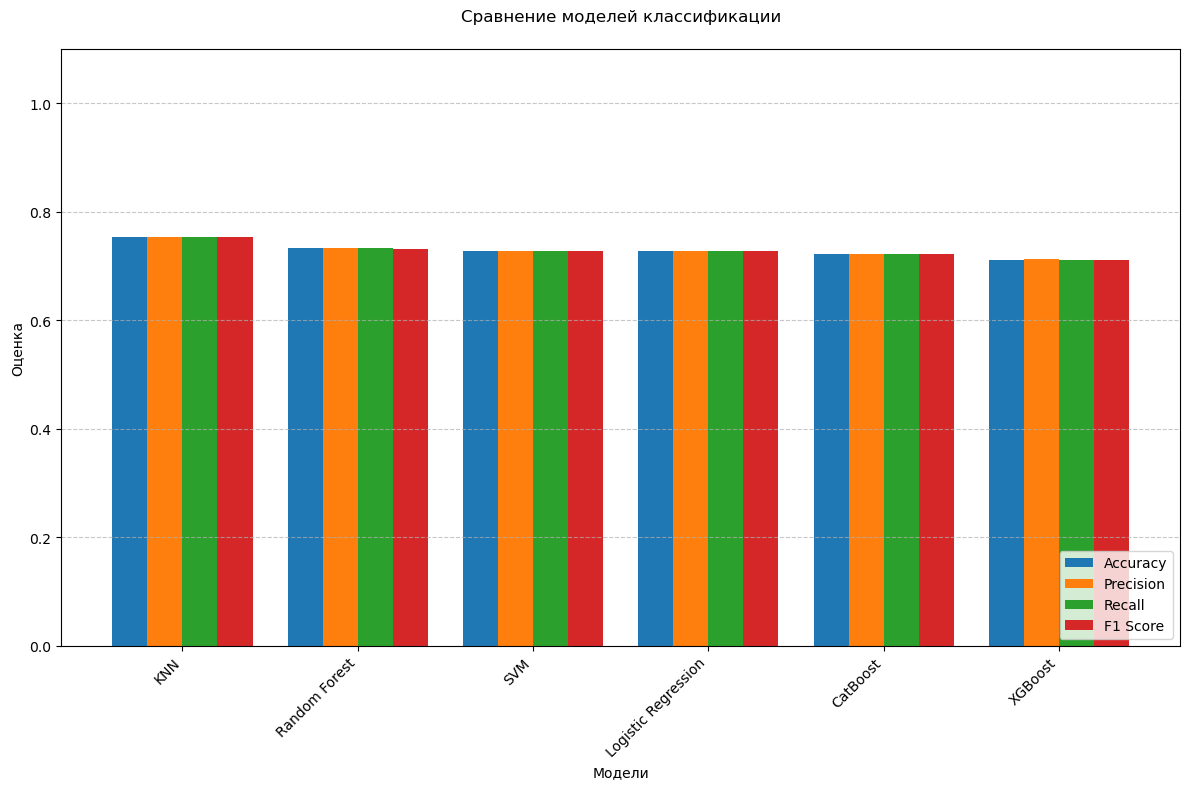

In [13]:

def test_classification_models_with_scaling(X, y, test_size=0.2, random_state=42, verbose=True):
    """
    Тестирует классификационные модели со стандартизацией данных и возвращает результаты.

    Параметры:
    ----------
    X : pd.DataFrame или np.array
        Матрица признаков
    y : pd.Series или np.array
        Целевая переменная
    test_size : float, optional
        Размер тестовой выборки (по умолчанию 0.2)
    random_state : int, optional
        Seed для воспроизводимости (по умолчанию 42)
    verbose : bool, optional
        Выводить ли прогресс (по умолчанию True)

    Возвращает:
    -----------
    pd.DataFrame
        Таблица с результатами метрик и временем обучения для каждой модели
    """

    # Разделение данных
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Инициализация моделей с пайплайнами (StandardScaler + модель)
    models = {
        'Logistic Regression': make_pipeline(StandardScaler(),
                                           LogisticRegression(random_state=random_state, max_iter=1000)),
        'SVM': make_pipeline(StandardScaler(),
                            SVC(random_state=random_state)),
        'KNN': make_pipeline(StandardScaler(),
                            KNeighborsClassifier()),
        'Random Forest': RandomForestClassifier(random_state=random_state, n_jobs=-1),
        'XGBoost': XGBClassifier(random_state=random_state, n_jobs=-1, eval_metric='logloss'),
        'CatBoost': CatBoostClassifier(random_state=random_state, verbose=False)
    }

    # Словарь для хранения результатов
    results = {
        'Model': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1 Score': [],
        'Train Time (s)': [],
        'Scaler Used': []
    }

    # Обучение и оценка моделей
    for name, model in models.items():
        if verbose:
            print(f"🔍 Обучение {name}...")

        try:
            start_time = time.time()

            # Обучение модели
            model.fit(X_train, y_train)
            train_time = time.time() - start_time

            # Предсказание
            y_pred = model.predict(X_test)

            # Расчет метрик
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')

            # Определение использования StandardScaler
            scaler_used = 'StandardScaler' if 'standardscaler' in str(model).lower() else 'No'

            # Сохранение результатов
            results['Model'].append(name)
            results['Accuracy'].append(accuracy)
            results['Precision'].append(precision)
            results['Recall'].append(recall)
            results['F1 Score'].append(f1)
            results['Train Time (s)'].append(train_time)
            results['Scaler Used'].append(scaler_used)

            if verbose:
                print(f" {name}\nAccuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
                print(classification_report(y_test, y_pred))
                print("─" * 50)

        except Exception as e:
            print(f" Ошибка в {name}: {str(e)}")
            continue

    # Создание DataFrame с результатами
    results_df = pd.DataFrame(results).sort_values('F1 Score', ascending=False)

    # Визуализация результатов
    if verbose:
        plt.figure(figsize=(12, 8))
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
        x = np.arange(len(results_df['Model']))
        width = 0.2

        for i, metric in enumerate(metrics):
            plt.bar(x + i*width, results_df[metric], width, label=metric)

        plt.title('Сравнение моделей классификации', pad=20)
        plt.xlabel('Модели')
        plt.ylabel('Оценка')
        plt.xticks(x + width*1.5, results_df['Model'], rotation=45, ha='right')
        plt.ylim(0, 1.1)
        plt.legend(loc='lower right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    return results_df


# Запуск расчета
results = test_classification_models_with_scaling(X, y)

In [14]:
# Ищем наилучший набор признаков для повышения качества классификации
def evaluate_model(X, y, model, test_size=0.2, random_state=42):
    """Функция оценки модели классификации с добавлением StandardScaler"""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Для моделей, чувствительных к масштабу, используем Pipeline со StandardScaler
    if isinstance(model, (LogisticRegression, SVC, KNeighborsClassifier)):
        model = make_pipeline(StandardScaler(), model)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred, average='weighted')
    }

def find_best_feature_subset(X, y, model, model_name):
    """Модифицированная версия для классификации с указанием имени модели"""
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)

    current_features = X.columns.tolist()
    initial_scores = evaluate_model(X[current_features], y, model)
    best_f1 = initial_scores['f1']
    best_accuracy = initial_scores['accuracy']
    best_features = current_features.copy()
    history = []

    history.append({
        'features': current_features.copy(),
        'f1': best_f1,
        'accuracy': best_accuracy,
        'action': 'initial'
    })

    print(f"\n=== {model_name} ===")
    print(f"Initial F1: {best_f1:.4f}, Accuracy: {best_accuracy:.4f} with {len(current_features)} features")

    improved = True
    while improved and len(current_features) > 1:
        improved = False
        worst_feature = None

        for feature in current_features:
            trial_features = [f for f in current_features if f != feature]
            current_scores = evaluate_model(X[trial_features], y, model)

            history.append({
                'features': trial_features.copy(),
                'f1': current_scores['f1'],
                'accuracy': current_scores['accuracy'],
                'action': f'removed {feature}'
            })

            if current_scores['f1'] > best_f1:
                best_f1 = current_scores['f1']
                best_accuracy = current_scores['accuracy']
                best_features = trial_features.copy()
                worst_feature = feature
                improved = True

        if improved:
            current_features.remove(worst_feature)

    print(f"Best F1: {best_f1:.4f}, Accuracy: {best_accuracy:.4f} with {len(best_features)} features")
    print("Optimal features:", best_features)

    return {
        'model': model_name,
        'best_f1': best_f1,
        'best_accuracy': best_accuracy,
        'best_features': best_features,
        'num_features': len(best_features),
        'selector': 'without selection'
    }

def test_all_models(X, y):
    """Тестирование всех классификационных моделей по очереди"""
    # Создаем модели с дефолтными параметрами
    models = [
        ('LogisticRegression', LogisticRegression(max_iter=1000, random_state=42)),
        ('SVM', SVC(random_state=42)),
        ('KNN', KNeighborsClassifier()),
        ('RandomForest', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('XGBoost', XGBClassifier(random_state=42, eval_metric='logloss')),
        ('CatBoost', CatBoostClassifier(silent=True, random_state=42))
    ]

    results = []

    for name, model in models:
        try:
            result = find_best_feature_subset(X, y, model, name)
            results.append(result)
        except Exception as e:
            print(f"Error with {name}: {str(e)}")
            continue

    # Создаем DataFrame с результатами
    results_df = pd.DataFrame(results)

    return results_df

# Запуск расчета
results_col_combination = test_all_models(X, y)


=== LogisticRegression ===
Initial F1: 0.7267, Accuracy: 0.7268 with 210 features
Best F1: 0.7679, Accuracy: 0.7680 with 204 features
Optimal features: ['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SM

In [176]:
# Ищем наилучший набор признаков для повышения качества классификации, через последовательное удаление признаков, упорядоченных по количеству возможных выбросов

outliers_count = pd.DataFrame({
        'feature': df.columns,
        'outliers': outliers.sum(axis=0)
    }).sort_values('outliers', ascending=False)
all_features_outliers = outliers_count['feature'][outliers_count['outliers']>0].tolist()


def test_all_models(X, y):
    """Тестирование всех классификационных моделей"""
    models = [
        ('LogisticRegression', LogisticRegression(max_iter=1000, random_state=42)),
        ('SVM', SVC(probability=True, random_state=42)),
        ('KNN', KNeighborsClassifier()),
        ('RandomForest', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('XGBoost', XGBClassifier(random_state=42, eval_metric='logloss')),
        ('CatBoost', CatBoostClassifier(silent=True, random_state=42))
    ]

    results = []

    for name, model in models:
        try:
            result = get_best_features(X, y, name)
            results.append(result)
        except Exception as e:
            print(f"Error with {name}: {str(e)}")
            continue

    return pd.DataFrame(results)

def get_best_features(X, y, model_name):
    """
    Отбор признаков с удалением выбросов для классификации

    Возвращает:
    - best_features: список лучших признаков
    - best_metrics: лучшие метрики
    """
    best_metrics = {
        'accuracy': 0,
        'f1': 0,
        'roc_auc': 0
    }
    best_features = []
    removed = []
    # Перебираем количество удаляемых признаков с выбросами
    for n in range(1, len(all_features_outliers)+1):
        
        current_features = X.drop(columns = all_features_outliers[:n]).columns.tolist()

        metrics = evaluate_metrics(X[current_features], y, model_name)

        if metrics['f1'] > best_metrics['f1']:
            best_metrics = metrics
            best_features = current_features.copy()
            removed = all_features_outliers[:n]
    print(f"\n=== {model_name} ===")
    print(f"Best Metrics: {best_metrics}")
    print(f"Selected features: {len(best_features)} (Removed {len(removed)} outliers)")
    return {
        'model': model_name,
        'best_f1': best_metrics['f1'],
        'best_accuracy': best_metrics['accuracy'],
        'best_features': best_features,
        'num_features': len(best_features),
        'selector': 'outliers'
    }
   

def evaluate_metrics(X, y, model_name):
    """
    Оценка метрик классификации
    """
    models = {
        'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
        'SVM': make_pipeline(StandardScaler(), SVC(probability=True, random_state=42)),
        'KNN': make_pipeline(StandardScaler(), KNeighborsClassifier()),
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
        'CatBoost': CatBoostClassifier(silent=True, random_state=42)
    }

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

    model = models[model_name]
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred, average='weighted')
    }

    if y_proba is not None and len(np.unique(y)) == 2:
        metrics['roc_auc'] = roc_auc_score(y_test, y_proba)
    else:
        metrics['roc_auc'] = None

    return metrics

# Запуск расчета
results_col_combination_2 = test_all_models(X, y)


=== LogisticRegression ===
Best Metrics: {'accuracy': 0.7628865979381443, 'f1': 0.7627857522594366, 'roc_auc': 0.8139547242002337}
Selected features: 131 (Removed 79 outliers)

=== SVM ===
Best Metrics: {'accuracy': 0.7422680412371134, 'f1': 0.7422406462585034, 'roc_auc': 0.7990753533850569}
Selected features: 198 (Removed 12 outliers)

=== KNN ===
Best Metrics: {'accuracy': 0.788659793814433, 'f1': 0.788654178291484, 'roc_auc': 0.8278244234243809}
Selected features: 133 (Removed 77 outliers)

=== RandomForest ===
Best Metrics: {'accuracy': 0.7525773195876289, 'f1': 0.7525510204081632, 'roc_auc': 0.8218726750983102}
Selected features: 56 (Removed 154 outliers)

=== XGBoost ===
Best Metrics: {'accuracy': 0.7474226804123711, 'f1': 0.7474159691776273, 'roc_auc': 0.8008821341268998}
Selected features: 47 (Removed 163 outliers)

=== CatBoost ===
Best Metrics: {'accuracy': 0.7680412371134021, 'f1': 0.767985754910038, 'roc_auc': 0.8271335954936763}
Selected features: 63 (Removed 147 outliers

In [16]:
# Ищем наилучший набор признаков с учетом значимости признаков определенных с помощью SHAP

def test_tree_models_sh(X, y):
    """Тестирование всех моделей классификации с SHAP-анализом"""
    models = {
        "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
        "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
        "CatBoost": CatBoostClassifier(silent=True, random_state=42),
    }

    results = []

    for name, model in models.items():
        try:
            result = get_shap_selection(X, y, name)
            results.append(result)
        except Exception as e:
            print(f"Error with {name}: {str(e)}")
            continue

    return pd.DataFrame(results)

def get_shap_selection(X, y, name):
    """
    Отбор признаков с помощью SHAP для классификации

    Возвращает:
    - best_features: список лучших признаков
    - best_metrics: лучшие метрики
    - all_features: все признаки отсортированные по важности
    """
    feature_names = X.columns.tolist()

    if name == 'RandomForest':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)
        explainer = shap.Explainer(model)
        shap_values = explainer(X)
        importance = get_significant_shap_features(shap_values, feature_names)
    elif name == 'XGBoost':
        model = XGBRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)
        explainer = shap.Explainer(model)
        shap_values = explainer(X)
        importance = get_significant_shap_features(shap_values, feature_names)
    elif name == 'CatBoost':
        model = CatBoostRegressor(
        iterations=100,
        random_seed=42,
        verbose=False
        )
        model.fit(X, y)
        explainer = shap.Explainer(model)
        shap_values = explainer(X)
        importance = get_significant_shap_features(shap_values, feature_names)
   
    feat_importance = pd.DataFrame({
        'feature': importance['feature'],
        'importance': importance['mean_abs_shap']
    }).sort_values('importance', ascending=False)
    
    all_features = feat_importance['feature'][feat_importance['importance']>0].tolist()
    
    
    # Находим оптимальное количество признаков
    best_metrics = {
        'accuracy': 0,
        'f1': 0,
        'roc_auc': 0
    }
    best_features = []

    for n in range(1, min(20, len(all_features)+1)):  # Ограничиваем до 20 признаков для скорости
        current_features = all_features[:n]
        current_metrics = evaluate_classification_metrics(X[current_features], y, name)

        if current_metrics['f1'] > best_metrics['f1']:
            best_metrics = current_metrics
            best_features = current_features.copy()

    print(f"\n=== {name} ===")
    print(f"Best Metrics: Accuracy={best_metrics['accuracy']:.4f}, F1={best_metrics['f1']:.4f}, ROC-AUC={best_metrics.get('roc_auc', 'N/A')}")
    print(f"Optimal features ({len(best_features)}): {best_features[:5]}...")  # Показываем первые 5 признаков

    return {
        'model': name,
        'best_f1': best_metrics['f1'],
        'best_accuracy': best_metrics['accuracy'],
        'best_features': best_features,
        'num_features': len(best_features),
        'selector': 'shap'
    }

def evaluate_classification_metrics(X, y, model_name, test_size=0.2, random_state=42):
    """
    Оценка метрик классификации
    """
    models = {
        "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
        "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
        "CatBoost": CatBoostClassifier(silent=True, random_state=42),
    }

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )

    model = models[model_name]
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred, average='weighted')
    }

    if y_proba is not None and len(np.unique(y)) == 2:
        metrics['roc_auc'] = roc_auc_score(y_test, y_proba)

    return metrics

def get_significant_shap_features(shap_values, feature_names, threshold=0):
    """
    Возвращает отсортированный по убыванию список признаков с SHAP-значимостью

    Параметры:
    ----------
    shap_values : shap.Explanation или np.ndarray
        SHAP значения для всех наблюдений
    feature_names : list или pd.Index
        Список названий признаков
    threshold : float, optional
        Порог значимости (по умолчанию 0)

    Возвращает:
    -----------
    pd.DataFrame: DataFrame с колонками 'feature' и 'mean_abs_shap',
                  отсортированный по убыванию важности
    """
    if isinstance(shap_values, shap.Explanation):
        shap_array = shap_values.values
    else:
        shap_array = shap_values

    # Для многоклассовой классификации берем среднее по всем классам
    if len(shap_array.shape) == 3:
        mean_abs_shap = np.abs(shap_array).mean(axis=(0, 1))
    else:
        mean_abs_shap = np.abs(shap_array).mean(axis=0)

    shap_importance = pd.DataFrame({
        'feature': feature_names,
        'mean_abs_shap': mean_abs_shap
    })

    significant_features = shap_importance[shap_importance['mean_abs_shap'] > threshold] \
        .sort_values('mean_abs_shap', ascending=False)
    
    return significant_features.reset_index(drop=True)

# Запуск расчета
results_col_combination_3 = test_tree_models_sh(X, y)


=== RandomForest ===
Best Metrics: Accuracy=0.7423, F1=0.7422, ROC-AUC=0.7974279944733765
Optimal features (17): ['VSA_EState8', 'BCUT2D_MRLOW', 'NumHDonors', 'VSA_EState4', 'MolLogP']...

=== XGBoost ===
Best Metrics: Accuracy=0.7268, F1=0.7268, ROC-AUC=0.7730364544584971
Optimal features (18): ['VSA_EState8', 'BCUT2D_MRLOW', 'NumHDonors', 'EState_VSA4', 'FpDensityMorgan3']...

=== CatBoost ===
Best Metrics: Accuracy=0.7165, F1=0.7164, ROC-AUC=0.7684663619938357
Optimal features (10): ['BCUT2D_MRLOW', 'PEOE_VSA6', 'EState_VSA4', 'FpDensityMorgan3', 'NumSaturatedCarbocycles']...


In [17]:
# Ищем наилучший набор признаков с учетом значимости признаков определенных с помощью features importance

def test_tree_models_fs(X, y):
    """Тестирование всех моделей классификации с отбором признаков"""
    models = {
        "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
        "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
        "CatBoost": CatBoostClassifier(silent=True, random_state=42),
    }
    
    results = []
    
    for name, model in models.items():
        try:
            result = get_feature_selection(X, y, name)
            results.append(result)
        except Exception as e:
            print(f"Error with {name}: {str(e)}")
            continue
    
    return pd.DataFrame(results)

def get_feature_selection(X, y, name):
    """
    Отбор признаков для классификации на основе важности признаков
    
    Возвращает:
    - best_features: список лучших признаков
    - best_metrics: лучшие метрики
    - all_features: все признаки отсортированные по важности
    """
    feature_names = X.columns.tolist()
    
    # Инициализация и обучение модели
    if name == 'RandomForest':
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    elif name == 'XGBoost':
        model = XGBClassifier(random_state=42, eval_metric='logloss')
    elif name == 'CatBoost':
        model = CatBoostClassifier(iterations=100, random_seed=42, verbose=False)
    
    model.fit(X, y)
    
    # Получение важности признаков
    if name == 'XGBoost':
        importance = model.feature_importances_
    else:
        importance = model.feature_importances_
    
    # Сортировка признаков по важности
    feat_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    all_features = feat_importance['feature'].tolist()
    
    # Поиск оптимального набора признаков
    best_metrics = {
        'accuracy': 0,
        'f1': 0,
        'roc_auc': 0
    }
    best_features = []
    
    # Ограничиваем количество проверяемых комбинаций для скорости
    max_features_to_test = min(20, len(all_features))
    
    for n in range(1, max_features_to_test + 1):
        current_features = all_features[:n]
        current_metrics = evaluate_classification_metrics(X[current_features], y, name)
        
        if current_metrics['f1'] > best_metrics['f1']:
            best_metrics = current_metrics
            best_features = current_features.copy()
    
    print(f"\n=== {name} ===")
    print(f"Best Metrics: Accuracy={best_metrics['accuracy']:.4f}, F1={best_metrics['f1']:.4f}, ROC-AUC={best_metrics.get('roc_auc', 'N/A')}")
    print(f"Optimal features ({len(best_features)}): {best_features[:5]}...")  # Показываем первые 5 признаков

    return {
        'model': name,
        'best_f1': best_metrics['f1'],
        'best_accuracy': best_metrics['accuracy'],
        'best_features': best_features,
        'num_features': len(best_features),
        'selector': 'feature_importance'
    }
    

def evaluate_classification_metrics(X, y, model_name, test_size=0.2, random_state=42):
    """
    Оценка метрик классификации
    """
    models = {
        "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
        "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
        "CatBoost": CatBoostClassifier(silent=True, random_state=42),
    }
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=random_state,
        stratify=y
    )
    
    model = models[model_name]
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred, average='weighted')
    }
    
    if y_proba is not None and len(np.unique(y)) == 2:
        metrics['roc_auc'] = roc_auc_score(y_test, y_proba)
    
    return metrics

# Запуск расчета
results_col_combination_4  = test_tree_models_fs(X, y)


=== RandomForest ===
Best Metrics: Accuracy=0.7474, F1=0.7474, ROC-AUC=0.7960994792220216
Optimal features (17): ['VSA_EState8', 'BCUT2D_MRLOW', 'MolLogP', 'SlogP_VSA5', 'BCUT2D_LOGPHI']...

=== XGBoost ===
Best Metrics: Accuracy=0.7165, F1=0.7165, ROC-AUC=0.7770751408226166
Optimal features (17): ['NumHDonors', 'VSA_EState8', 'fr_ketone_Topliss', 'NumHeteroatoms', 'fr_ketone']...

=== CatBoost ===
Best Metrics: Accuracy=0.7320, F1=0.7319, ROC-AUC=0.8182059730045701
Optimal features (20): ['BCUT2D_MRLOW', 'VSA_EState8', 'NHOHCount', 'NumSaturatedHeterocycles', 'VSA_EState1']...


In [18]:
# Объединяем все лучшие результаты
results_df = pd.concat([results_col_combination,results_col_combination_2, results_col_combination_3, results_col_combination_4], ignore_index = True)

In [19]:
results_df

,model,best_f1,best_accuracy,best_features,num_features,selector
0,LogisticRegression,0.767887,0.768041,"[MaxAbsEStateIndex, MaxEStateIndex, MinAbsESta...",204,without selection
1,SVM,0.773099,0.773196,"[MaxAbsEStateIndex, MaxEStateIndex, MinAbsESta...",203,without selection
2,KNN,0.824724,0.824742,"[MaxEStateIndex, MinAbsEStateIndex, MinEStateI...",198,without selection
3,RandomForest,0.747255,0.747423,"[MaxAbsEStateIndex, MaxEStateIndex, MinAbsESta...",208,without selection
4,XGBoost,0.752472,0.752577,"[MaxAbsEStateIndex, MaxEStateIndex, MinAbsESta...",208,without selection
5,CatBoost,0.742241,0.742268,"[MaxAbsEStateIndex, MaxEStateIndex, MinAbsESta...",209,without selection
6,LogisticRegression,0.731930,0.731959,"[MaxAbsEStateIndex, MaxEStateIndex, MinAbsESta...",196,outliers
7,SVM,0.742241,0.742268,"[MaxAbsEStateIndex, MaxEStateIndex, MinAbsESta...",198,outliers
8,KNN,0.778203,0.778351,"[MaxAbsEStateIndex, MaxEStateIndex, MinAbsESta...",195,outliers
9,RandomForest,0.737106,0.737113,"[MaxAbsEStateIndex, MaxEStateIndex, MinAbsESta...",201,outliers


In [20]:
# Определяем налучший результат работы моделей
def test_all_classifiers(X, y):
    """Тестирование всех классификаторов"""
    models = [
        ('LogisticRegression', LogisticRegression(max_iter=1000, random_state=42)),
        ('SVM', SVC(probability=True, random_state=42)),
        ('KNN', KNeighborsClassifier()),
        ('RandomForest', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('XGBoost', XGBClassifier(random_state=42, eval_metric='logloss')),
        ('CatBoost', CatBoostClassifier(silent=True, random_state=42))
    ]
    
    results = []
    
    for name, model in models:
        try:
            result = evaluate_classifier(X, y, name)
            results.append(result)
        except Exception as e:
            print(f"Error with {name}: {str(e)}")
            continue
    
    return pd.DataFrame(results)

def evaluate_classifier(X, y, model_name):
    """
    Оценка классификатора с оптимальным набором признаков
    
    Возвращает:
    - best_features: список лучших признаков
    - best_metrics: лучшие метрики
    """
    # Находим оптимальные метрики
    best_metrics = {
        'accuracy': 0,
        'f1': 0,
        'roc_auc': 0
    }
    best_features = []
    
    # Получаем все наборы признаков из предыдущих результатов
    feature_sets = [set(features) for features in results_df['best_features']]
    
    # Добавляем все признаки для сравнения
    feature_sets.append(set(X.columns))
    
    # Удаляем дубликаты
    unique_feature_sets = []
    seen = set()
    for fs in feature_sets:
        frozen = frozenset(fs)
        if frozen not in seen:
            seen.add(frozen)
            unique_feature_sets.append(list(fs))
    
    for current_features in unique_feature_sets:
        current_metrics = get_classification_metrics(X[current_features], y, model_name)
        
        if current_metrics['f1'] > best_metrics['f1']:
            best_metrics = current_metrics
            best_features = current_features.copy()
    
    print(f"\n=== {model_name} ===")
    print(f"Best Metrics: Accuracy={best_metrics['accuracy']:.4f}, F1={best_metrics['f1']:.4f}, ROC-AUC={best_metrics.get('roc_auc', 'N/A')}")
    print(f"Optimal features ({len(best_features)}): {best_features[:5]}...")

    return {
        'model': model_name,
        'best_f1': best_metrics['f1'],
        'best_accuracy': best_metrics['accuracy'],
        'best_features': best_features,
        'num_features': len(best_features)
        
    }
    

def get_classification_metrics(X, y, model_name, test_size=0.2, random_state=42):
    """
    Оценка метрик классификации
    """
    models = {
        'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
        'SVM': make_pipeline(StandardScaler(), SVC(probability=True, random_state=42)),
        'KNN': make_pipeline(StandardScaler(), KNeighborsClassifier()),
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
        'CatBoost': CatBoostClassifier(silent=True, random_state=42)
    }
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=random_state,
        stratify=y
    )
    
    model = models[model_name]
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred, average='weighted')
    }
    
    if y_proba is not None and len(np.unique(y)) == 2:
        metrics['roc_auc'] = roc_auc_score(y_test, y_proba)
    
    return metrics

# Запуск расчета
results_features_selection  = test_all_classifiers(X, y)


=== LogisticRegression ===
Best Metrics: Accuracy=0.7320, F1=0.7319, ROC-AUC=0.8023700712084173
Optimal features (198): ['SlogP_VSA7', 'VSA_EState7', 'fr_ketone', 'NumRotatableBonds', 'fr_alkyl_halide']...

=== SVM ===
Best Metrics: Accuracy=0.7732, F1=0.7731, ROC-AUC=0.8065150387926453
Optimal features (203): ['SlogP_VSA7', 'VSA_EState7', 'fr_ketone', 'NumRotatableBonds', 'fr_alkyl_halide']...

=== KNN ===
Best Metrics: Accuracy=0.8247, F1=0.8247, ROC-AUC=0.847433308534382
Optimal features (198): ['VSA_EState7', 'fr_ketone', 'NumRotatableBonds', 'fr_alkyl_halide', 'VSA_EState8']...

=== RandomForest ===
Best Metrics: Accuracy=0.7320, F1=0.7319, ROC-AUC=0.7928579020087151
Optimal features (204): ['SlogP_VSA7', 'VSA_EState7', 'fr_ketone', 'NumRotatableBonds', 'fr_alkyl_halide']...

=== XGBoost ===
Best Metrics: Accuracy=0.7320, F1=0.7319, ROC-AUC=0.7904665745562759
Optimal features (20): ['BCUT2D_MRLOW', 'HallKierAlpha', 'SlogP_VSA5', 'SMR_VSA1', 'VSA_EState8']...

=== CatBoost ===
Bes

In [21]:
results_features_selection

,model,best_f1,best_accuracy,best_features,num_features
0,LogisticRegression,0.731930,0.731959,"[SlogP_VSA7, VSA_EState7, fr_ketone, NumRotata...",198
1,SVM,0.773099,0.773196,"[SlogP_VSA7, VSA_EState7, fr_ketone, NumRotata...",203
2,KNN,0.824724,0.824742,"[VSA_EState7, fr_ketone, NumRotatableBonds, fr...",198
3,RandomForest,0.731930,0.731959,"[SlogP_VSA7, VSA_EState7, fr_ketone, NumRotata...",204
4,XGBoost,0.731930,0.731959,"[BCUT2D_MRLOW, HallKierAlpha, SlogP_VSA5, SMR_...",20
5,CatBoost,0.757726,0.757732,"[BCUT2D_MRLOW, Chi0n, NumHeteroatoms, SlogP_VS...",17


In [89]:
# Определяем лучшую комбинацию строк для повышения качества работы моделей на всех данных

def test_all_classifiers_optimized(X, y):
    """Тестирование всех классификаторов с оптимизацией набора данных"""
    models = [
        ('LogisticRegression', LogisticRegression(max_iter=1000, random_state=42)),
        ('SVM', SVC(probability=True, random_state=42)),
        ('KNN', KNeighborsClassifier()),
        ('RandomForest', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('XGBoost', XGBClassifier(random_state=42, eval_metric='logloss')),
        ('CatBoost', CatBoostClassifier(silent=True, random_state=42))
    ]
    
    results = []
    
    for name, model in models:
        try:
            result = optimize_classifier_data(X, y, name, model)
            results.append(result)
        except Exception as e:
            print(f"Error with {name}: {str(e)}")
            continue
    
    return pd.DataFrame(results)

def optimize_classifier_data(X, y, name, model, verbose=True):
    """
    Оптимизирует набор данных для классификатора путем последовательного удаления строк
    
    Параметры:
    ----------
    X : pd.DataFrame
        Признаки
    y : pd.Series
        Целевая переменная
    name : str
        Имя модели
    model : sklearn classifier
        Модель классификатора
    verbose : bool
        Выводить ли прогресс
    
    Возвращает:
    -----------
    dict: Результаты оптимизации
    """
    # Используем оптимальные признаки для модели
    models = {
        'LogisticRegression': make_pipeline(StandardScaler(),LogisticRegression(max_iter=1000, random_state=42)),
        'SVM': make_pipeline(StandardScaler(), SVC(probability=True, random_state=42)),
        'KNN': make_pipeline(StandardScaler(), KNeighborsClassifier()),
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
        'CatBoost': CatBoostClassifier(silent=True, random_state=42)
    }
    if name == 'LogisticRegression':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][0]]
        
    elif name == 'SVM':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][1]]
        
    elif name == 'KNN':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][2]]
    elif name == 'RandomForest':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][3]]
    elif name == 'XGBoost':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][4]]
    elif name == 'CatBoost':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][5]]
    
    
    # Разделение данных со стратификацией
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42,
        stratify=y
    )
    
    # Инициализация
    X_opt = X_train.copy()
    y_opt = y_train.copy()
    best_metrics = {
        'accuracy': 0,
        'f1': 0,
        'roc_auc': 0
    }
    removed_indices = []
    
    # Прогресс-бар для наглядности
    iterator = tqdm(X_train.index, desc=f"Optimizing {name}") if verbose else X_train.index
    
    for idx in iterator:
        # Временно удаляем строку
        X_temp = X_opt.drop(index=idx)
        y_temp = y_opt.drop(index=idx)
        
        # Обучаем и оцениваем
        model = models[name]
        model.fit(X_temp, y_temp)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Рассчитываем метрики
        current_metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred, average='weighted')
        }
        
        if y_proba is not None and len(np.unique(y)) == 2:
            current_metrics['roc_auc'] = roc_auc_score(y_test, y_proba)
        
        # Решение о сохранении/удалении строки
        if current_metrics['f1'] > best_metrics['f1']:
            best_metrics = current_metrics
            X_opt = X_temp
            y_opt = y_temp
            removed_indices.append(idx)
    
    print(f"\n=== {name} ===")
    print(f"Best Metrics: Accuracy={best_metrics['accuracy']:.4f}, F1={best_metrics['f1']:.4f}, ROC-AUC={best_metrics.get('roc_auc', 'N/A')}")
    print(f"Удалено строк: {len(removed_indices)} из {len(X_train)}")
    
    
    return {
        'model': name,
        'best_f1': best_metrics['f1'],
        'best_accuracy': best_metrics['accuracy'],
        'removed_indices': removed_indices,
        'num_removed': len(removed_indices),
        'indices': X_opt.index.tolist(),
        'selector': 'without selection'
    }
    
# Запуск расчета
results_indices_selection = test_all_classifiers_optimized(X, y)

Optimizing LogisticRegression: 100%|██████████| 772/772 [00:18<00:00, 41.73it/s]



=== LogisticRegression ===
Best Metrics: Accuracy=0.7732, F1=0.7731, ROC-AUC=0.8012009777872251
Удалено строк: 9 из 772


Optimizing SVM: 100%|██████████| 772/772 [02:15<00:00,  5.68it/s]



=== SVM ===
Best Metrics: Accuracy=0.7835, F1=0.7835, ROC-AUC=0.8075778509937294
Удалено строк: 3 из 772


Optimizing KNN: 100%|██████████| 772/772 [00:19<00:00, 40.60it/s]



=== KNN ===
Best Metrics: Accuracy=0.8557, F1=0.8556, ROC-AUC=0.8585396960357106
Удалено строк: 7 из 772


Optimizing RandomForest: 100%|██████████| 772/772 [03:04<00:00,  4.19it/s]



=== RandomForest ===
Best Metrics: Accuracy=0.7629, F1=0.7629, ROC-AUC=0.815070677011372
Удалено строк: 10 из 772


Optimizing XGBoost: 100%|██████████| 772/772 [00:49<00:00, 15.66it/s]



=== XGBoost ===
Best Metrics: Accuracy=0.7732, F1=0.7732, ROC-AUC=0.8021575087682007
Удалено строк: 7 из 772


Optimizing CatBoost: 100%|██████████| 772/772 [15:18<00:00,  1.19s/it]


=== CatBoost ===
Best Metrics: Accuracy=0.7887, F1=0.7887, ROC-AUC=0.816080348602402
Удалено строк: 7 из 772


In [23]:
results_indices_selection

,model,best_f1,best_accuracy,removed_indices,num_removed,indices,selector
0,LogisticRegression,0.762861,0.762887,"[322, 657, 617, 456, 176, 543]",6,"[338, 31, 656, 216, 93, 579, 519, 713, 300, 83...",without selection
1,SVM,0.783482,0.783505,"[322, 288, 662]",3,"[338, 31, 656, 216, 93, 579, 519, 713, 657, 30...",without selection
2,KNN,0.855609,0.855670,"[322, 31, 758, 997, 296, 153, 711]",7,"[338, 656, 216, 93, 579, 519, 713, 657, 300, 8...",without selection
3,RandomForest,0.762861,0.762887,"[322, 483, 20, 974, 641, 254, 376, 918, 512, 358]",10,"[338, 31, 656, 216, 93, 579, 519, 713, 657, 30...",without selection
4,XGBoost,0.773172,0.773196,"[322, 93, 955, 692, 88, 595, 131]",7,"[338, 31, 656, 216, 579, 519, 713, 657, 300, 8...",without selection
5,CatBoost,0.788654,0.788660,"[322, 836, 56, 224, 891, 3, 307]",7,"[338, 31, 656, 216, 93, 579, 519, 713, 657, 30...",without selection


In [101]:
# Определяем налучшую комбинацию строк для повышения качества работы моделей
def optimize_classifier(X_train, X_test, y_train, y_test, model_type='logistic', n_trials=100, random_state=42):
    """
    Оптимизирует гиперпараметры для классификаторов с улучшенной обработкой ошибок SVM
    
    Параметры:
    ----------
    model_type : str
        Тип модели: 'logistic', 'svm' или 'knn'
    n_trials : int
        Количество испытаний для Optuna
    random_state : int
        Seed для воспроизводимости
        
    Возвращает:
    -----------
    dict: Результаты оптимизации (лучшие параметры, метрики, study)
    """
    
    def objective(trial):
    # Проверяем, является ли это первым trial (нулевым по индексу)
        
            # Обычная логика подбора параметров
        try:
            if model_type == 'logistic':
                params = {
                    'C': trial.suggest_float('C', 1e-4, 100, log=True),
                    'penalty': trial.suggest_categorical('penalty', ['l2', 'l1']),
                    'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
                    'max_iter': trial.suggest_int('max_iter', 100, 1000)
                }
                model = make_pipeline(StandardScaler(),LogisticRegression(**params, random_state=random_state))
                
            elif model_type == 'svm':
                kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
                params = {
                    'C': trial.suggest_float('C', 1e-4, 100, log=True),
                    'kernel': kernel,
                    'gamma': trial.suggest_float('gamma', 1e-5, 10, log=True),
                    'tol': trial.suggest_float('tol', 1e-5, 1e-1, log=True),
                    'max_iter': trial.suggest_int('max_iter', 100, 1000)
                }
                if kernel == 'poly':
                    params['degree'] = trial.suggest_int('degree', 2, 5)
                
                model = make_pipeline(StandardScaler(),SVC(**params, random_state=random_state, probability=True))
                
            elif model_type == 'knn':
                params = {
                    'n_neighbors': trial.suggest_int('n_neighbors', 1, 30),
                    'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
                    'p': trial.suggest_int('p', 1, 3)
                }
                model = make_pipeline(StandardScaler(),KNeighborsClassifier(**params))
        
        except Exception as e:
            if model_type == 'svm':
                error_info = f"SVM failed with params: {params}. Error: {str(e)}"
                trial.set_user_attr("svm_error", error_info)
            return float('-inf')
        
        # Общая часть для всех моделей (дефолтных и оптимизированных)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        
        f1 = f1_score(y_test, y_pred, average='weighted')
        trial.set_user_attr("accuracy", accuracy_score(y_test, y_pred))
        
        if y_proba is not None and len(np.unique(y_train)) == 2:
            trial.set_user_attr("roc_auc", roc_auc_score(y_test, y_proba))
        
        return f1
        
    study = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=random_state),
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
    )
    
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    
    # Анализ результатов
    best_params = study.best_params
    best_metrics = {
        'f1': study.best_value,
        'accuracy': study.best_trial.user_attrs['accuracy'],
    }
    
    if 'roc_auc' in study.best_trial.user_attrs:
        best_metrics['roc_auc'] = study.best_trial.user_attrs['roc_auc']
    
    # Добавляем информацию о неудачных trials для SVM
    if model_type == 'svm':
        failed_trials = [t for t in study.trials if 'svm_error' in t.user_attrs]
        if failed_trials:
            best_metrics['failed_trials_count'] = len(failed_trials)
            best_metrics['last_error'] = failed_trials[-1].user_attrs['svm_error']
    
    return {
        'model_type': model_type,
        'best_params': best_params,
        'best_metrics': best_metrics,
        'study': study
    }

In [121]:
# Запуск подбора гиперпараметров

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
X_train_logistic = X_train[results_features_selection[results_features_selection['model'] == 'LogisticRegression']['best_features'][0]].drop(results_indices_selection[results_indices_selection['model'] == 'LogisticRegression']['removed_indices'][0])
y_train_logistic = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'LogisticRegression']['removed_indices'][0])
X_test_logistic = X_test[results_features_selection[results_features_selection['model'] == 'LogisticRegression']['best_features'][0]]
logistic_results = optimize_classifier(X_train_logistic, X_test_logistic, y_train_logistic, y_test, 'logistic', n_trials=200)

X_train_svm = X_train[results_features_selection[results_features_selection['model'] == 'SVM']['best_features'][1]].drop(index=results_indices_selection[results_indices_selection['model'] == 'SVM']['removed_indices'][1])
y_train_svm = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'SVM']['removed_indices'][1])
X_test_svm = X_test[results_features_selection[results_features_selection['model'] == 'SVM']['best_features'][1]]
svm_results = optimize_classifier(X_train_svm, X_test_svm, y_train_svm, y_test, 'svm', n_trials=200)
X_train_knn = X_train[results_features_selection[results_features_selection['model'] == 'KNN']['best_features'][2]].drop(results_indices_selection[results_indices_selection['model'] == 'KNN']['removed_indices'][2])
y_train_knn = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'KNN']['removed_indices'][2])
X_test_knn = X_test[results_features_selection[results_features_selection['model'] == 'KNN']['best_features'][2]]
knn_results = optimize_classifier(X_train_knn, X_test_knn, y_train_knn, y_test, 'knn', n_trials=200)


In [123]:
# Вывод результатов подбора гиперпараметров для линейных моделей
print(f"LogisticRegression best params: {logistic_results['best_params']}")
print(f"LogisticRegression best f1: {logistic_results['best_metrics']['f1']:.4f}")
print(f"LogisticRegression best accuracy: {logistic_results['best_metrics']['accuracy']:.4f}")
print(f"SVM best params: {svm_results['best_params']}")
print(f"SVM best f1: {svm_results['best_metrics']['f1']:.4f}")
print(f"SVM best accuracy: {svm_results['best_metrics']['accuracy']:.4f}")
print(f"KNN best params: {knn_results['best_params']}")
print(f"KNN best f1: {knn_results['best_metrics']['f1']:.4f}")
print(f"KNN best accuracy: {knn_results['best_metrics']['accuracy']:.4f}")

LogisticRegression best params: {'C': 87.73712049661573, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 475}
LogisticRegression best f1: 0.7680
LogisticRegression best accuracy: 0.7680
SVM best params: {'kernel': 'rbf', 'C': 0.9365132873713495, 'gamma': 0.005688551861154316, 'tol': 0.002866449889135651, 'max_iter': 482}
SVM best f1: 0.7835
SVM best accuracy: 0.7835
KNN best params: {'n_neighbors': 5, 'weights': 'uniform', 'p': 2}
KNN best f1: 0.8556
KNN best accuracy: 0.8557


In [153]:
# Подбор гиперпараметров для CatBoost
# Подготовка данных для CatBoost

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_cb = X_train[results_features_selection[results_features_selection['model'] == 'CatBoost']['best_features'][5]].drop(results_indices_selection[results_indices_selection['model'] == 'CatBoost']['removed_indices'][5])
y_train_cb = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'CatBoost']['removed_indices'][5])
X_test_cb = X_test[results_features_selection[results_features_selection['model'] == 'CatBoost']['best_features'][5]]

def objective(trial):
    """Функция для оптимизации гиперпараметров CatBoostClassifier"""
    
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
        'loss_function': 'MultiClass' if len(y_train_cb.unique()) > 2 else 'Logloss',
        'silent': True,
        'random_seed': 42,
        'thread_count': 4
    }
    
    model = CatBoostClassifier(**params)
    
    # Обучение модели
    model.fit(
        X_train_cb, 
        y_train_cb,
        eval_set=(X_test_cb, y_test),
        early_stopping_rounds=20,
        verbose=0
    )
    
    # Предсказание и метрики
    y_pred = model.predict(X_test_cb)
    y_proba = model.predict_proba(X_test_cb)[:, 1] if len(y_train_cb.unique()) == 2 else None
    
    # Основная метрика - F1-score (взвешенный)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Сохраняем дополнительные метрики
    trial.set_user_attr("accuracy", accuracy_score(y_test, y_pred))
    if y_proba is not None:
        trial.set_user_attr("roc_auc", roc_auc_score(y_test, y_proba))
    
    return f1

def log_trial_progress(study, trial):
    """Callback для логирования прогресса"""
    if trial.number == 0:
        print("| Trial |   F1     | Accuracy | ROC-AUC  |")
        print("|-------|----------|----------|----------|")
    
    f1 = trial.value if trial.value is not None else 0
    acc = trial.user_attrs.get("accuracy", 0)
    roc_auc = trial.user_attrs.get("roc_auc", "N/A")
    
    print(f"| {trial.number:5} | {f1:.6f} | {acc:.6f} | {roc_auc if isinstance(roc_auc, str) else roc_auc:.6f} |")

# Настройка исследования Optuna
study = optuna.create_study(
    direction='maximize',  # Максимизируем F1-score
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_warmup_steps=10)
)

# Запуск оптимизации
try:
    print("Optimizing CatBoost Classifier...")
    study.optimize(
        objective,
        n_trials=500,
        #callbacks=[log_trial_progress],
        gc_after_trial=True
    )
except KeyboardInterrupt:
    print("\nOptimization stopped by user")

# Анализ результатов
if len(study.trials) > 0:
    best_trial_cb = study.best_trial
    
    print("\nBest trial:")
    print(f"  F1-score: {best_trial_cb.value:.6f}")
    print(f"  Accuracy: {best_trial_cb.user_attrs['accuracy']:.6f}")
    if 'roc_auc' in best_trial_cb.user_attrs:
        print(f"  ROC-AUC: {best_trial_cb.user_attrs['roc_auc']:.6f}")
    print("\nBest params:")
    for key, value in best_trial_cb.params.items():
        print(f"  {key}: {value}")
    
    # Лучшая модель
    best_params = best_trial_cb.params
    best_params.update({
        'loss_function': 'MultiClass' if len(y_train_cb.unique()) > 2 else 'Logloss',
        'silent': True,
        'random_seed': 42
    })
    
    best_model = CatBoostClassifier(**best_params)
    best_model.fit(
        pd.concat([X_train_cb, X_test_cb]),
        pd.concat([y_train_cb, y_test]),
        verbose=0
    )

Optimizing CatBoost Classifier...

Best trial:
  F1-score: 0.814789
  Accuracy: 0.814433
  ROC-AUC: 0.852648

Best params:
  iterations: 705
  depth: 9
  learning_rate: 0.10770010910094868
  l2_leaf_reg: 3.595910511863626
  random_strength: 9.832420369289425
  bagging_temperature: 0.6728343909051019
  border_count: 33
  min_data_in_leaf: 25


In [152]:
# Подбор гиперпараметров для XGBoost
# Подготовка данных для XGBoost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
X_train = X_train[results_features_selection[results_features_selection['model'] == 'XGBoost']['best_features'][4]].drop(results_indices_selection[results_indices_selection['model'] == 'XGBoost']['removed_indices'][4])
y_train = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'XGBoost']['removed_indices'][4])
X_test = X_test[results_features_selection[results_features_selection['model'] == 'XGBoost']['best_features'][4]]

def objective_xgb(trial):
    """Функция для оптимизации гиперпараметров XGBoost (классификация)"""
    
    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': 42,
        'n_jobs': -1,
        'eval_metric': 'logloss',
        'early_stopping_rounds': 20  # Перенесено сюда
    }
    
    # Автоматическое определение типа задачи
    if len(np.unique(y_train)) > 2:
        xgb_params['objective'] = 'multi:softmax'
        xgb_params['num_class'] = len(np.unique(y_train))
    else:
        xgb_params['objective'] = 'binary:logistic'

    model = XGBClassifier(**xgb_params)
    model.fit(
        X_train, 
        y_train,
        eval_set=[(X_test, y_test)],  # Оставлено здесь
        verbose=0
    )
    
    # Остальной код без изменений
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if len(np.unique(y_train)) == 2 else None
    
    f1 = f1_score(y_test, y_pred, average='weighted')
    trial.set_user_attr("accuracy", accuracy_score(y_test, y_pred))
    if y_proba is not None:
        trial.set_user_attr("roc_auc", roc_auc_score(y_test, y_proba))
    
    return f1

def log_trial_progress(study, trial):
    """Callback для логирования прогресса"""
    if trial.number == 0:
        print("| Trial |   F1     | Accuracy | ROC-AUC  |")
        print("|-------|----------|----------|----------|")
    
    f1 = trial.value if trial.value is not None else 0
    acc = trial.user_attrs.get("accuracy", 0)
    roc_auc = trial.user_attrs.get("roc_auc", "N/A")
    
    print(f"| {trial.number:5} | {f1:.6f} | {acc:.6f} | {roc_auc if isinstance(roc_auc, str) else roc_auc:.6f} |")

# Настройка исследования Optuna
study_xgb = optuna.create_study(
    direction='maximize',  # Максимизируем F1-score
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_warmup_steps=10)
)

# Запуск оптимизации
try:
    print("Optimizing XGBoost Classifier...")
    study_xgb.optimize(
        objective_xgb,
        n_trials=500,
        #callbacks=[log_trial_progress],
        gc_after_trial=True
    )
except KeyboardInterrupt:
    print("\nOptimization stopped by user")

# Анализ результатов
if len(study_xgb.trials) > 0:
    best_trial_xgb = study_xgb.best_trial
    
    print("\nBest XGBoost Classifier:")
    print(f"  F1-score: {best_trial_xgb.value:.6f}")
    print(f"  Accuracy: {best_trial_xgb.user_attrs['accuracy']:.6f}")
    if 'roc_auc' in best_trial_xgb.user_attrs:
        print(f"  ROC-AUC: {best_trial_xgb.user_attrs['roc_auc']:.6f}")
    print("\nBest params:")
    for key, value in best_trial_xgb.params.items():
        print(f"  {key}: {value}")
    
    # Лучшая модель
    best_params = best_trial_xgb.params
    best_params.update({
        'objective': 'multi:softmax' if len(np.unique(y_train)) > 2 else 'binary:logistic',
        'random_state': 42,
        'n_jobs': -1
    })
    
    if len(np.unique(y_train)) > 2:
        best_params['num_class'] = len(np.unique(y_train))
    
    best_xgb = XGBClassifier(**best_params)
    best_xgb.fit(
        pd.concat([X_train, X_test]),
        pd.concat([y_train, y_test]),
        verbose=0
    )

Optimizing XGBoost Classifier...

Best XGBoost Classifier:
  F1-score: 0.778203
  Accuracy: 0.778351
  ROC-AUC: 0.817143

Best params:
  n_estimators: 405
  max_depth: 8
  learning_rate: 0.17804954060277914
  subsample: 0.6462412740238879
  colsample_bytree: 0.7579368653630655
  gamma: 0.023045002178660144
  reg_alpha: 7.036008267490183
  reg_lambda: 9.130441034469362


In [150]:
# Подбор гиперпараметров для RandomForest
# Подготовка данных для RandomForest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
X_train = X_train[results_features_selection[results_features_selection['model'] == 'RandomForest']['best_features'][3]].drop(results_indices_selection[results_indices_selection['model'] == 'RandomForest']['removed_indices'][3])
y_train = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'RandomForest']['removed_indices'][3])
X_test = X_test[results_features_selection[results_features_selection['model'] == 'RandomForest']['best_features'][3]]

def objective_rf(trial):
    """Функция для оптимизации гиперпараметров RandomForest (классификация)"""
    
    rf_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'random_state': 42,
        'n_jobs': -1,
        'criterion': 'gini'  # Можно добавить выбор между 'gini' и 'entropy'
    }

    model = RandomForestClassifier(**rf_params)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if len(np.unique(y_train)) == 2 else None
    
    # Основная метрика - F1-score (взвешенный для многоклассовой)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Сохраняем дополнительные метрики
    trial.set_user_attr("accuracy", accuracy_score(y_test, y_pred))
    if y_proba is not None:
        trial.set_user_attr("roc_auc", roc_auc_score(y_test, y_proba))
    
    return f1

def log_trial_progress(study, trial):
    """Callback для логирования прогресса"""
    if trial.number == 0:
        print("| Trial |   F1     | Accuracy | ROC-AUC  |")
        print("|-------|----------|----------|----------|")
    
    f1 = trial.value if trial.value is not None else 0
    acc = trial.user_attrs.get("accuracy", 0)
    roc_auc = trial.user_attrs.get("roc_auc", "N/A")
    
    print(f"| {trial.number:5} | {f1:.6f} | {acc:.6f} | {roc_auc if isinstance(roc_auc, str) else roc_auc:.6f} |")

# Настройка исследования Optuna
study_rf = optuna.create_study(
    direction='maximize',  # Максимизируем F1-score
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_warmup_steps=10)
)

# Запуск оптимизации
try:
    print("Optimizing RandomForest Classifier...")
    study_rf.optimize(
        objective_rf,
        n_trials=500,
        #callbacks=[log_trial_progress],
        gc_after_trial=True
    )
except KeyboardInterrupt:
    print("\nOptimization stopped by user")

# Анализ результатов
if len(study_rf.trials) > 0:
    best_trial_rf = study_rf.best_trial
    
    print("\nBest RandomForest Classifier:")
    print(f"  F1-score: {best_trial_rf.value:.6f}")
    print(f"  Accuracy: {best_trial_rf.user_attrs['accuracy']:.6f}")
    if 'roc_auc' in best_trial_rf.user_attrs:
        print(f"  ROC-AUC: {best_trial_rf.user_attrs['roc_auc']:.6f}")
    print("\nBest params:")
    for key, value in best_trial_rf.params.items():
        print(f"  {key}: {value}")
    
    # Лучшая модель
    best_params = best_trial_rf.params
    best_params.update({
        'random_state': 42,
        'n_jobs': -1
    })
    
    best_rf = RandomForestClassifier(**best_params)
    best_rf.fit(
        pd.concat([X_train, X_test]),
        pd.concat([y_train, y_test])
    )

Optimizing RandomForest Classifier...

Best RandomForest Classifier:
  F1-score: 0.767739
  Accuracy: 0.768041
  ROC-AUC: 0.809597

Best params:
  n_estimators: 443
  max_depth: 4
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: 0.15795879437070806
  bootstrap: False
  class_weight: None


In [166]:
# Собираем лучшие результаты
best_results_total = []
logistic = {
        'model': results_indices_selection[results_indices_selection['model'] == 'LogisticRegression']['model'][0],
        'best_f1':  logistic_results['best_metrics']['f1'],
        'best_accuracy':  logistic_results['best_metrics']['accuracy'],
        'count_features': len(results_features_selection[results_features_selection['model'] == 'LogisticRegression']['best_features'][0]),
        'count_strings': len(results_indices_selection[results_indices_selection['model'] == 'LogisticRegression']['indices'][0])
    }
best_results_total.append(logistic)
svm = {
        'model': results_indices_selection[results_indices_selection['model'] == 'SVM']['model'][1],
        'best_f1':  svm_results['best_metrics']['f1'],
        'best_accuracy':  svm_results['best_metrics']['accuracy'],
        'count_features': len(results_features_selection[results_features_selection['model'] == 'SVM']['best_features'][1]),
        'count_strings': len(results_indices_selection[results_indices_selection['model'] == 'SVM']['indices'][1])
    }
best_results_total.append(svm)
knn = {
        'model': results_indices_selection[results_indices_selection['model'] == 'KNN']['model'][2],
        'best_f1':  knn_results['best_metrics']['f1'],
        'best_accuracy':  knn_results['best_metrics']['accuracy'],
        'count_features': len(results_features_selection[results_features_selection['model'] == 'KNN']['best_features'][2]),
        'count_strings': len(results_indices_selection[results_indices_selection['model'] == 'KNN']['indices'][2])
    }
best_results_total.append(knn)
rf = {
        'model': results_indices_selection[results_indices_selection['model'] == 'RandomForest']['model'][3],
        'best_f1':  best_trial_rf.value,
        'best_accuracy':  best_trial_rf.user_attrs['accuracy'],
        'count_features': len(results_features_selection[results_features_selection['model'] == 'RandomForest']['best_features'][3]),
        'count_strings': len(results_indices_selection[results_indices_selection['model'] == 'RandomForest']['indices'][3])
    }
best_results_total.append(rf)

xg = {
        'model': results_indices_selection[results_indices_selection['model'] == 'XGBoost']['model'][4],
        'best_f1':  best_trial_xgb.value,
        'best_accuracy':  best_trial_xgb.user_attrs['accuracy'],
        'count_features': len(results_features_selection[results_features_selection['model'] == 'XGBoost']['best_features'][4]),
        'count_strings': len(results_indices_selection[results_indices_selection['model'] == 'XGBoost']['indices'][4])
    }
best_results_total.append(xg)
cb = {
        'model': results_indices_selection[results_indices_selection['model'] == 'CatBoost']['model'][5],
        'best_f1':  best_trial_cb.value,
        'best_accuracy':  best_trial_cb.user_attrs['accuracy'],
        'count_features': len(results_features_selection[results_features_selection['model'] == 'CatBoost']['best_features'][5]),
        'count_strings': len(results_indices_selection[results_indices_selection['model'] == 'CatBoost']['indices'][5])
    }
best_results_total.append(cb)

best_results_total_df = pd.DataFrame(best_results_total)

In [168]:
# Лучшие результаты
best_results_total_df

,model,best_f1,best_accuracy,count_features,count_strings
0,LogisticRegression,0.767986,0.768041,198,763
1,SVM,0.783482,0.783505,203,769
2,KNN,0.855609,0.855670,198,765
3,RandomForest,0.767739,0.768041,204,762
4,XGBoost,0.778203,0.778351,20,765
5,CatBoost,0.814789,0.814433,17,765
